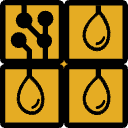

# Importing Libraries

In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import root_mean_squared_error
path = "C:/Users/Omid/Desktop/MDTE/Challenge 2/DT/DATASETS"
os.chdir(path)

#  Importing the dataset

In [2]:
GT = pd.read_csv('gt_full.csv')
GT.head()

,Unnamed: 0,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952
1,2,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377
2,3,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776
3,4,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505
4,5,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028


In [3]:


Target = GT[['CO','NOX']]

Feature = GT.drop(columns=['CO','NOX',],axis=1)

In [4]:
Feature.drop(columns=['Unnamed: 0'],axis=1, inplace=True)

In [5]:
X , X_test , Y , Y_test = train_test_split(Feature,Target['CO'],train_size=0.85,random_state=42)

In [6]:

final_model_CO = LGBMRegressor(learning_rate=0.1,
                            n_estimators=500,
                            num_leaves = 31,
                            subsample = 0.7)

In [7]:



# Columns for transformations
PCA_Columns = ['GTEP','TIT','TEY','CDP']
Standard_Columns = ['AP','AT','AFDP']
Robust_columns = ['AH','TAT']
columns_to_drop = list(range(len(Robust_columns)+len(Standard_Columns)+2,
                       len(Standard_Columns)+len(Robust_columns)+2+len(PCA_Columns)))



preprocessor = ColumnTransformer([
    ('standard', StandardScaler(), Standard_Columns),  
    ('robust', RobustScaler(), Robust_columns),
    ('PCA_pipline', Pipeline([
        ('scaling', StandardScaler()),
        ('PCA', PCA(n_components=2))
    ]), PCA_Columns)
], remainder='passthrough')

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, column_names_to_drop):
        self.column_names_to_drop = column_names_to_drop
        self.drop_indices = None  # Will be set after fit()

    def fit(self, X, y=None):
        feature_names = (X.columns if isinstance(X, pd.DataFrame)
                         else [f"feature_{i}" for i in range(X.shape[1])])
        self.drop_indices = [feature_names.index(col) 
                             for col in self.column_names_to_drop 
                             if col in feature_names]
        return self

    def transform(self, X):
        return np.delete(X, self.drop_indices, axis=1)

pip = Pipeline([
    ('Preprocessing', preprocessor),
    ('ColumnDrop', DropColumns(columns_to_drop)),
    ('LightGBoost', final_model_CO)  # your LightGBM model
])



In [8]:
preprocessor.get_feature_names_out

<bound method ColumnTransformer.get_feature_names_out of ColumnTransformer(remainder='passthrough',
                  transformers=[('standard', StandardScaler(),
                                 ['AP', 'AT', 'AFDP']),
                                ('robust', RobustScaler(), ['AH', 'TAT']),
                                ('PCA_pipline',
                                 Pipeline(steps=[('scaling', StandardScaler()),
                                                 ('PCA', PCA(n_components=2))]),
                                 ['GTEP', 'TIT', 'TEY', 'CDP'])])>

In [9]:
pip.get_feature_names_out

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard', StandardScaler(),
                                                  ['AP', 'AT', 'AFDP']),
                                                 ('robust', RobustScaler(),
                                                  ['AH', 'TAT']),
                                                 ('PCA_pipline',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler()),
                                                                  ('PCA',
                                                                   PCA(n_components=2))]),
                                                  ['GTEP', 'TIT', 'TEY',
                                                   'CDP'])])),
                ('ColumnDrop', Dr

In [8]:
columns_to_drop

[7, 8, 9, 10]

In [9]:
pip.fit(X,Y)
Y_pred_CO = pip.predict(X_test)

c:\Users\Omid\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1725
[LightGBM] [Info] Number of data points in the train set: 31223, number of used features: 7
[LightGBM] [Info] Start training from score 2.371235


c:\Users\Omid\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [10]:


RMSE_CO = root_mean_squared_error(Y_test,Y_pred_CO)

print(f"Root Mean Square Error for CO emission is :   {RMSE_CO}")

Root Mean Square Error for CO emission is :   1.083754252383733


#### plotting actual/predict ration for CO

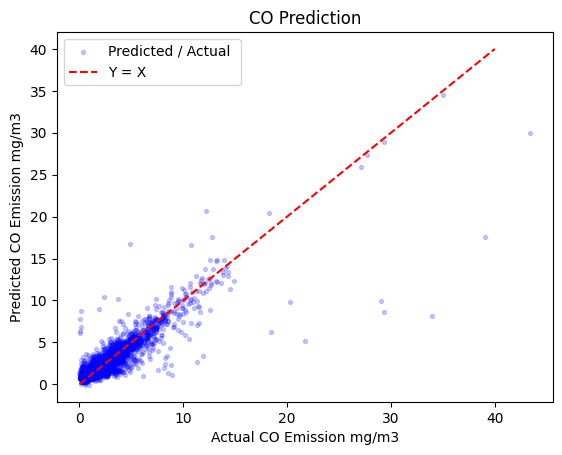

In [11]:
plt.figure()
plt.title('CO Prediction')
plt.scatter(Y_test,Y_pred_CO,s=8,alpha = 0.2, c = 'blue',label = 'Predicted / Actual ')
plt.plot([0,40],[0,40],
         color='red',
         linestyle = '--',
         label = 'Y = X')
plt.xlabel('Actual CO Emission mg/m3')
plt.ylabel('Predicted CO Emission mg/m3')
plt.legend(loc = 'upper left')
plt.show()

# Pipline for NOX

In [12]:
X_NOX , X_test_NOX , Y_NOX , Y_test_NOX = train_test_split(Feature,Target['NOX'],train_size=0.85,random_state=42)

In [13]:
final_model_NOX = LGBMRegressor(learning_rate=0.1,
                            n_estimators=600,
                            num_leaves = 50,
                            subsample = 0.7)
pip_NOX = Pipeline([
    ('Preprocessing', preprocessor),
    ('ColumnDrop', DropColumns(columns_to_drop)),
    ('LightGBoost', final_model_NOX)  # your LightGBM model
])


In [15]:
pip_NOX.fit(X_NOX,Y_NOX)
Y_pred_NOX = pip_NOX.predict(X_test_NOX)

c:\Users\Omid\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1725
[LightGBM] [Info] Number of data points in the train set: 31223, number of used features: 7
[LightGBM] [Info] Start training from score 65.299733


c:\Users\Omid\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [16]:
RMSE_NOX = root_mean_squared_error(Y_test_NOX,Y_pred_NOX)
print(f"Root Mean Square Error for NOX emission is :   {RMSE_NOX}")

Root Mean Square Error for NOX emission is :   3.9388134591099084


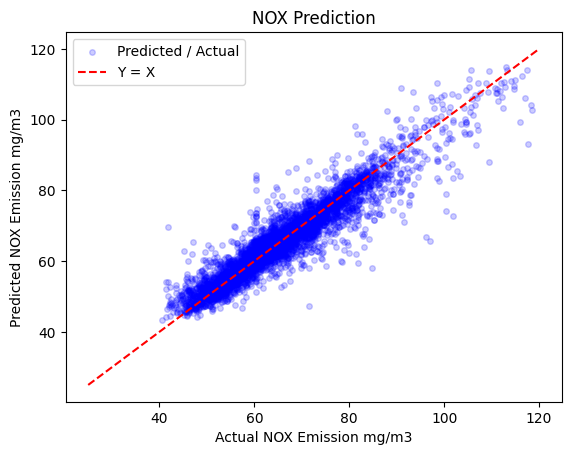

In [17]:
plt.figure()
plt.title('NOX Prediction')
plt.scatter(Y_test_NOX,Y_pred_NOX , s=16,alpha=0.2 , c='blue',
            label = 'Predicted / Actual')
plt.plot([25,120],[25,120],color='red',linestyle = '--',
         label = 'Y = X')
plt.legend(loc = 'upper left')
plt.xlabel('Actual NOX Emission mg/m3')
plt.ylabel('Predicted NOX Emission mg/m3')
plt.show()